# Data Cleaning and EDA #
The script has gathered up to 100 reviews per user for almost 300 users. Time to make sure all the data is present

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = os.path.abspath(
            os.path.join(
                os.pardir,
                'data',
                'external'
                )
            )
books_csv_path = os.path.abspath(os.path.join(data_path, 'books.csv'))

ratings_csv_path = os.path.abspath(os.path.join(data_path, 'ratings.csv'))

In [3]:
books_df = pd.read_csv(books_csv_path,  usecols = ['book_id', 'best_book_id', 'authors', 'title', 'image_url'])
books_df.head()

,book_id,best_book_id,authors,title,image_url
0,1,2767052,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",https://images.gr-assets.com/books/1447303603m...
1,2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,https://images.gr-assets.com/books/1474154022m...
2,3,41865,Stephenie Meyer,"Twilight (Twilight, #1)",https://images.gr-assets.com/books/1361039443m...
3,4,2657,Harper Lee,To Kill a Mockingbird,https://images.gr-assets.com/books/1361975680m...
4,5,4671,F. Scott Fitzgerald,The Great Gatsby,https://images.gr-assets.com/books/1490528560m...


In [4]:
ratings_df = pd.read_csv(ratings_csv_path)
ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
ratings_df.dtypes

user_id    int64
book_id    int64
rating     int64
dtype: object

# SQL Database Exploration #
Now I want to check out the relational database I made from the data

In [6]:
database_path = os.path.abspath(
            os.path.join(
                os.pardir,
                'data',
                'processed',
                'goodbooks.db'
                )
            )

conn = sqlite3.connect(database_path)

In [7]:
cur = conn.cursor()
cur.execute('SELECT * FROM Ratings LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, 258, 5)
(2, 4081, 4)
(2, 260, 5)
(2, 9296, 5)
(2, 2318, 3)
(2, 26, 4)
(2, 315, 3)
(2, 33, 4)
(2, 301, 5)
(2, 2686, 5)


In [8]:
cur = conn.cursor()
cur.execute('SELECT * FROM Books LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, 2767052, 'Suzanne Collins', 'The Hunger Games (The Hunger Games, #1)', 'https://images.gr-assets.com/books/1447303603m/2767052.jpg')
(2, 3, 'J.K. Rowling, Mary GrandPré', "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 'https://images.gr-assets.com/books/1474154022m/3.jpg')
(3, 41865, 'Stephenie Meyer', 'Twilight (Twilight, #1)', 'https://images.gr-assets.com/books/1361039443m/41865.jpg')
(4, 2657, 'Harper Lee', 'To Kill a Mockingbird', 'https://images.gr-assets.com/books/1361975680m/2657.jpg')
(5, 4671, 'F. Scott Fitzgerald', 'The Great Gatsby', 'https://images.gr-assets.com/books/1490528560m/4671.jpg')
(6, 11870085, 'John Green', 'The Fault in Our Stars', 'https://images.gr-assets.com/books/1360206420m/11870085.jpg')
(7, 5907, 'J.R.R. Tolkien', 'The Hobbit', 'https://images.gr-assets.com/books/1372847500m/5907.jpg')
(8, 5107, 'J.D. Salinger', 'The Catcher in the Rye', 'https://images.gr-assets.com/books/1398034300m/5107.jpg')
(9, 960, 'Dan Brown', 'Angels & Demons  (R

In [9]:
cur.execute('SELECT COUNT(*) FROM Books')
book_count = cur.fetchone()
print(book_count)

(10000,)


In [14]:
cur.execute('SELECT COUNT(*) FROM Ratings')
rating_count = cur.fetchone()
print(rating_count)

(5976479,)


In [12]:
cur.execute('SELECT COUNT(DISTINCT user_id) FROM Ratings')
user_count = cur.fetchone()
print(user_count)

(53424,)


In [11]:
for row in conn.execute('PRAGMA table_info(Ratings)'):
    print(row)

(0, 'user_id', 'INTEGER', 0, None, 0)
(1, 'book_id', 'INTEGER', 0, None, 0)
(2, 'user_rating', 'INTEGER', 0, None, 0)


### Database Assessment ###
The database is correctly built with all books, users, and ratings accounted for! There are 10,000 unique books and 53,424 unique users combining for almost 6 million reviews.

## EDA ##
Now I want to take a look at the distributions of books and ratings.

### Most Popular Books ###

In [18]:
query = '''
SELECT b.title, AVG(r.user_rating) as avg_rating, COUNT(r.user_rating) as votes
FROM Books b
JOIN Ratings r ON b.book_id = r.book_id
GROUP BY b.title
LIMIT 10
'''
books_avg_ratings_df = pd.read_sql_query(query, conn)

In [19]:
books_avg_ratings_df.sort_values(by = ['votes', 'avg_rating'], ascending = [False, False]).head(10)

,title,avg_rating,votes
3,'Salem's Lot,3.938868,4433
4,"'Tis (Frank McCourt, #2)",3.570413,703
5,"1,000 Places to See Before You Die",3.728643,398
7,"10% Happier: How I Tamed the Voice in My Head,...",3.838384,297
0,"Angels (Walsh Family, #3)",3.562738,263
6,1/4 جرام,3.882653,196
2,#GIRLBOSS,3.476923,195
8,"100 Bullets, Vol. 1: First Shot, Last Call",3.617647,170
9,100 Love Sonnets,4.398551,138
1,"""حكايات فرغلي المستكاوي ""حكايتى مع كفر السحلاوية",3.407080,113


I don't actually recognize any of these titles.

In [20]:
ratings_df = pd.read_sql_query('SELECT * FROM Ratings', conn)
ratings_df.head()

,user_id,book_id,user_rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


### Least Popular Books ###
Although I sorted each user's shelf by most popular books, I'm curious to know which are the least popular books in the dataset.

In [21]:
num_reviews = ratings_df['book_id'].value_counts()
len(num_reviews.unique())

1902

In [22]:
len(ratings_df['book_id'].unique())

10000

There are 1902 unique value counts, so if I make a histogram with 1902 bins, each bin will account for a distinct value count. This way I can see the distribution of book popularity.

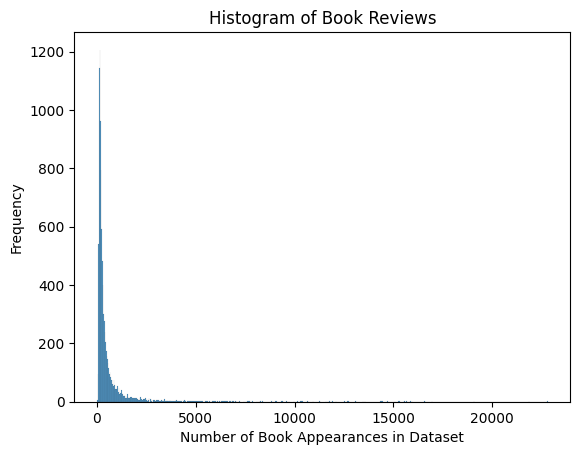

In [28]:
sns.histplot(data = num_reviews)#, bins = 1902)
plt.title('Histogram of Book Reviews')
plt.xlabel('Number of Book Appearances in Dataset')
#plt.ylim(0, 500)
plt.ylabel('Frequency')
plt.show()

The vast majority of books only appear a handful of times in the dataset, with a couple outliers making over 20,000 appearances.

In [29]:
min_books = 10
popular_filter = ratings_df['book_id'].value_counts() > min_books
popular_filter = popular_filter[popular_filter].index.to_list()
popular_df = ratings_df[ratings_df['book_id'].isin(popular_filter)]
len(popular_df['book_id'].value_counts().unique())

1901

Only 1901 books remain if I filter out the books with fewer than 10 reviews. I don't think this is a good idea. If I was starting with a much larger dataset I could make the argument for this approach, but I have too few books to eliminate most of them.

### User Rating Distribution ###
Now I want to see if user ratings are distributed normally.

The above histograms show the distribution of user ratings in blue and the distribution of average ratings in orange. It is not surprising that the most popular users would give the most popular books a high rating generally. I am a little surprised that these users give out so many 5-star reviews. While it is very subjective, many Goodreads users adhere to the same rating scale, where a 5-star rating is reserved for the user's favorite books of all time. But I suppose that popular, well-reviewed books are exactly that for a reason. The median book in this dataset has an average rating of just over 4 stars. The distribution of average ratings has a longer tail on the left, which makes sense due to the cap at 5 stars. I'm a little surprised to see that some of the books on this list managed to be popular enough but also average fewer than 3 stars.

In [33]:
query = '''
SELECT user_id, AVG(user_rating) as user_avg_rating
FROM Ratings
GROUP BY user_id
'''
user_avg_ratings_df = pd.read_sql_query(query, conn)

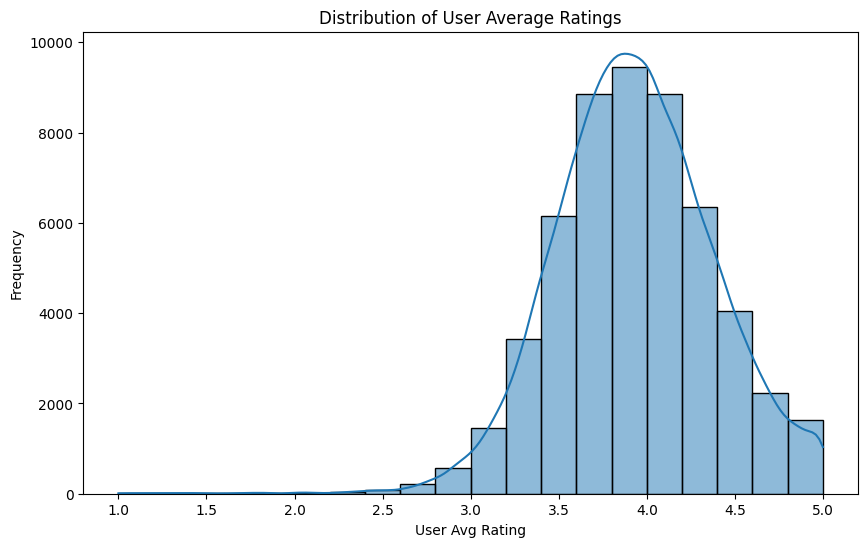

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings_df['user_avg_rating'], kde = True, bins = 20)
plt.title('Distribution of User Average Ratings')
plt.xlabel('User Avg Rating')
plt.ylabel('Frequency')
plt.show()

This histogram plot shows the distribution of each user's average rating. Some users clearly love the popular books, giving out an average of almost 5 stars.

### Low-Rater Investigation ###
I'll take a look at a particular user who gives out very low scores on average.

In [35]:
query = '''
SELECT user_id, SUM(user_rating == 0) AS zero_star, SUM(user_rating == 1) AS one_star, SUM(user_rating == 2) AS two_star,
SUM(user_rating == 3) AS three_star, SUM(user_rating == 4) AS four_star,
SUM(user_rating == 5) AS five_star, 
AVG(user_rating) AS user_avg
FROM Ratings r
GROUP BY user_id
HAVING AVG(user_rating) < 3
'''

low_ratings_df = pd.read_sql_query(query, conn)

In [36]:
low_ratings_df

,user_id,zero_star,one_star,two_star,three_star,four_star,five_star,user_avg
0,3,0,47,24,18,1,1,1.736264
1,53,0,9,12,14,7,7,2.816327
2,68,0,0,17,21,10,3,2.980392
3,80,0,15,13,22,7,7,2.656250
4,91,0,13,14,16,14,5,2.741935
...,...,...,...,...,...,...,...,...
959,53119,0,1,33,66,21,4,2.952000
960,53136,0,6,28,24,10,0,2.558824
961,53257,0,19,17,10,14,3,2.444444
962,53406,0,17,14,33,21,13,2.989796


In [20]:
conn.close()

# Conclusion #
This exploration has shown me that the most popular Goodreads users do not have a uniform system for rating books. Many of them use a similar scale : 
* 1 star - I did not like it
* 2 stars - It was fine
* 3 stars - I liked it
* 4 stars - I really liked it

Other users rate very differently. The model will have to account for these variations as it learns how to recommend books based on user similarity scores..